In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd

from sparse_shift.datasets import sample_cdnod_sim, \
    erdos_renyi_dag, connected_erdos_renyi_dag, barabasi_albert_dag
from sparse_shift.plotting import plot_dag
from sparse_shift.utils import create_causal_learn_dag
from sparse_shift.utils import dag2cpdag, cpdag2dags

from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz, kci
# from causallearn.utils.DAG2CPDAG import dag2cpdag
# from causallearn.utils.PDAG2DAG import pdag2dag

# Experimental setup
- Fix settings:
    - intervention sparsity, sample size, 2,...,E

- Simulate DAG

- Simulate intervention targets for each env

- Simulate data from each env

- Compute CPDAG (MEC) from DAG

- Learn full pool oracle PDAG
    - Compute TP, FP edges

- Learn pairwise pool oracle PDAG
 - Compute TP, FP edges

- Learn minimal changes result
    - Compute TP, FP edges

In [113]:
SPARSITY = 1
SAMPLE_SIZE = 100
N_ENV = 5
N_NODES = 4
DENSITY = 0.5

### Sample DAG

In [133]:
# Sample parent assignments
G_adj = erdos_renyi_dag(N_NODES, DENSITY)

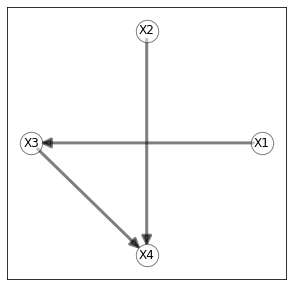

In [134]:
plot_dag(G_adj)

### Sample Data

In [173]:
# Sample targets
intv_targets = [np.random.choice(N_NODES, SPARSITY, replace=False) for _ in range(N_ENV)]

In [176]:
# Environment data
base_seed = 1234
Xs = [sample_cdnod_sim(
        G_adj,
        SAMPLE_SIZE,
        intervention_targets=targets,
        base_random_state=base_seed,
    ) for targets in intv_targets]

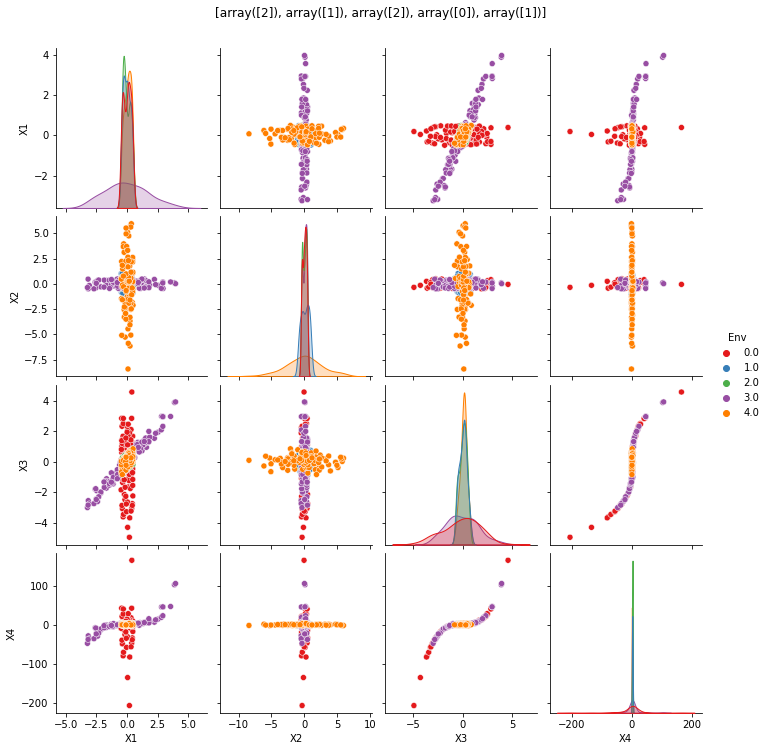

In [182]:
df = pd.DataFrame(
    np.hstack((
        np.vstack(Xs),
        np.hstack([[i]*X.shape[0] for i, X in enumerate(Xs)]).reshape(-1, 1)
    )),
    columns=[f'X{i+1}' for i in range(Xs[0].shape[1])] + ['Env']
)

sns.pairplot(df, hue='Env', palette='Set1')
plt.suptitle(intv_targets, y=1.04)
plt.show()

## Oracle tests

In [221]:
G_cl = create_causal_learn_dag(G_adj)
G_mec = dag2cpdag(G_cl)

X1
X2
X3
X4
X1
X2
X3
X1


In [230]:
G_2dag = pdag2dag(G_mec)

In [231]:
G_2dag.graph

array([[ 0,  0,  1,  0],
       [ 0,  0,  0,  1],
       [-1,  0,  0,  1],
       [ 0, -1, -1,  0]])

In [232]:
G_mec.graph

array([[ 0,  0, -1,  0],
       [ 0,  0,  0, -1],
       [-1,  0,  0, -1],
       [ 0, -1, -1,  0]])

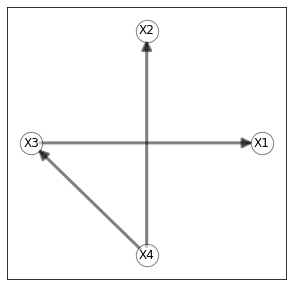

In [234]:
plot_dag(G_adj)

In [235]:
G_adj

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 1, 0]])

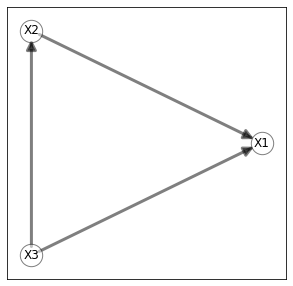

In [236]:
V_adj = np.asarray([[0, 0, 0], [1, 0, 0], [1, 1, 0]])
plot_dag(V_adj)

In [237]:
V_cl = create_causal_learn_dag(V_adj)
V_mec = dag2cpdag(V_cl)

X1
X2
X3
X1
X2
X1


In [238]:
V_2dag = pdag2dag(V_mec)

In [239]:
V_mec.graph

array([[ 0, -1, -1],
       [-1,  0, -1],
       [-1, -1,  0]])

In [240]:
V_2dag.graph

array([[ 0,  1,  1],
       [-1,  0,  1],
       [-1, -1,  0]])

## Augmented PC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd

from sparse_shift.datasets import sample_cdnod_sim, \
    erdos_renyi_dag, connected_erdos_renyi_dag, barabasi_albert_dag
from sparse_shift.plotting import plot_dag
from sparse_shift.utils import create_causal_learn_dag
from sparse_shift.utils import dag2cpdag, cpdag2dags

# from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
# # from causallearn.search.ConstraintBased.PC import pc
# from causallearn.utils.cit import fisherz, kci
# from sparse_shift.causal_learn.PC import augmented_pc
# from sparse_shift.causal_learn.SkeletonDiscovery import augmented_skeleton_discovery
# from causallearn.utils.PCUtils import Meek
# from sparse_shift.causal_learn.GraphClass import CausalGraph
# from causallearn.graph.GraphNode import GraphNode
# from causallearn.utils.DAG2CPDAG import dag2cpdag
# from causallearn.utils.PDAG2DAG import pdag2dag

In [83]:
# def _run_recursive_test(data, cpdag, alpha, test, test_kwargs):
#     from itertools import combinations

#     n_vars = cpdag.shape[0]
#     edges = set(list(range(n_vars)))
#     depth = -1
#     while np.max(cp.dag.sum(1)) - 1 > depth:
#         depth += 1
        
#         for x in range(n_vars):
#             neigh_x = np.where(cpdag[:, i] != 0)[0]
            
#             for S in combinations(neigh_x, depth):
#                 # n_vars is E
#                 p = test(data, x, n_vars, S, **test_kwargs)
#                 if p > alpha:
#                     edges.remove(x)
#                     break

#     return list(edges)


def _construct_augmented_cpdag(cpdag):
    from sparse_shift.utils import create_causal_learn_cpdag
    from sparse_shift.causal_learn.GraphClass import CausalGraph
    from causallearn.graph.GraphNode import GraphNode
    from causallearn.graph.Edge import Edge
    from causallearn.graph.Endpoint import Endpoint

    n_x_vars = cpdag.shape[0]
    cl_cpdag = create_causal_learn_cpdag(cpdag)
    cl_cpdag.add_node(GraphNode(f'X{n_x_vars+1}'))

    nodes = cl_cpdag.get_nodes()

    for i in range(n_x_vars):
        cl_cpdag.add_edge(Edge(nodes[i], nodes[-1], Endpoint.ARROW, Endpoint.TAIL))
    
    cg = CausalGraph(G=cl_cpdag)
    
    return cg

            
class AugmentedPC:
    """
    Runs the PC algorithm on an augmented graph, starting from a known MEC (optional).
    """
    def __init__(self, cpdag, test='kci', alpha=0.05, test_kwargs={}):
        self.cpdag = cpdag
        self.test = test
        self.alpha = alpha
        self.test_kwargs = test_kwargs
        self.dags_ = np.asarray(cpdag2dags(cpdag))
        self.n_vars_ = cpdag.shape[0]
        self.alpha_ = alpha
        self.n_envs_ = 0
        self.n_dags_ = self.dags_.shape[0]
        self.aug_cpdag_ = _construct_augmented_cpdag(cpdag)

    def learn_cpdag(self, Xs):
        if len(Xs) == 1:
            self.learned_cpdag_ = self.cpdag
            return
        
        data = np.block([
            [Xs[e], np.reshape([e] * Xs[e].shape[0], (-1, 1))]
            for e in range(len(Xs))
        ])
        
        if self.test == 'fisherz':
            from causallearn.utils.cit import fisherz
            test_func = fisherz
        elif self.test == 'kci':
            from causallearn.utils.cit import kci
            test_func = kci
        else:
            raise ValueError(f'Test {self.test} not implemented.')

        
        # Run meek rules on found edges
        from sparse_shift.causal_learn.SkeletonDiscovery import augmented_skeleton_discovery
        cg_skel_disc = augmented_skeleton_discovery(data, self.alpha_, test_func,
            stable=True,
            background_knowledge=None, verbose=False,
            show_progress=True, cg=self.aug_cpdag_)

        from causallearn.utils.PCUtils import Meek
        cg_meek = Meek.meek(cg_skel_disc, background_knowledge=None)
        
        adj = np.zeros(cg_meek.G.graph.shape)
        adj[cg_meek.G.graph > 0] = 1
        adj[np.abs(cg_meek.G.graph + cg_meek.G.graph.T) > 0] = 1
        
        self.learned_cpdag_ = adj[:-1, :-1]

    def get_dags(self):
        return cpdag2dags(self.get_cpdag())
    
    def get_cpdag(self):
        return self.learned_cpdag_

In [84]:
SPARSITY = 1
SAMPLE_SIZE = 100
N_ENV = 2
N_NODES = 4
DENSITY = 0.5

In [85]:
# Sample parent assignments
true_dag = erdos_renyi_dag(N_NODES, DENSITY, seed=2)

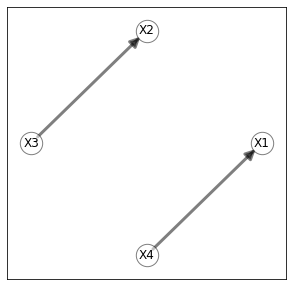

In [86]:
plot_dag(true_dag)

In [87]:
true_cpdag = dag2cpdag(true_dag)

In [88]:
apc = AugmentedPC(true_cpdag)

In [89]:
# Sample targets
intv_targets = [np.random.choice(N_NODES, SPARSITY, replace=False) for _ in range(N_ENV)]

intv_targets = [np.asarray([]), np.asarray([0])]

# Environment data
base_seed = 1234
Xs = [sample_cdnod_sim(
        true_dag,
        SAMPLE_SIZE,
        intervention_targets=targets,
        base_random_state=base_seed,
    ) for targets in intv_targets]

In [90]:
apc = AugmentedPC(true_cpdag)

apc.learn_cpdag(Xs)

  0%|          | 0/5 [00:00<?, ?it/s]

In [91]:
apc.get_cpdag()

array([[0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]])

In [98]:
from causallearn.graph.Edge import Edge
from causallearn.graph.Endpoint import Endpoint

cl_dag = create_causal_learn_dag(true_dag)

cl_cpdag = dag2cpdag(cl_dag)
cl_cpdag.add_node(GraphNode(f'X{N_NODES+1}'))

nodes = cl_cpdag.get_nodes()

for i in range(N_NODES):
    cl_cpdag.add_edge(Edge(nodes[i], nodes[-1], Endpoint.ARROW, Endpoint.TAIL))
    # break

X1
X2
X3
X4
X1
X2


In [99]:
cg = CausalGraph(G=cl_cpdag)

Green: undirected; Blue: directed; Red: bi-directed



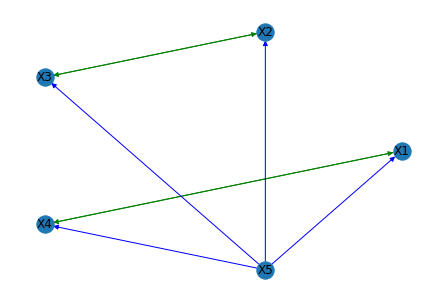

In [100]:
cg.to_nx_graph()
cg.draw_nx_graph(skel=False)

In [146]:
# Run PC w/ background knowledge
cg_skel_disc = augmented_skeleton_discovery(data, 0.05, kci, stable=True,
    background_knowledge=None, verbose=False,
    show_progress=True, cg=cg)

cg_meek = Meek.meek(cg_skel_disc, background_knowledge=None)


  0%|          | 0/5 [00:00<?, ?it/s]

In [147]:
from causaldag import DAG, PDAG

In [148]:
adj = np.zeros(cg_meek.G.graph.shape)
adj[cg_meek.G.graph > 0] = 1
adj[np.abs(cg_meek.G.graph + cg_meek.G.graph.T) > 0] = 1

In [149]:
cg_meek.G.graph

array([[ 0.,  0.,  0., -1.,  1.],
       [ 0.,  0., -1.,  0.,  0.],
       [ 0., -1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.]])

In [150]:
adj

array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

Green: undirected; Blue: directed; Red: bi-directed



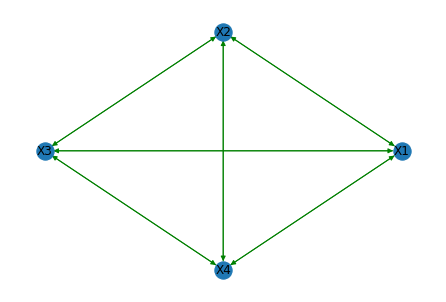

In [83]:
from causallearn.graph.GraphClass import CausalGraph
G = CausalGraph(4)
G.to_nx_graph()
G.draw_nx_graph(skel=False)

Green: undirected; Blue: directed; Red: bi-directed



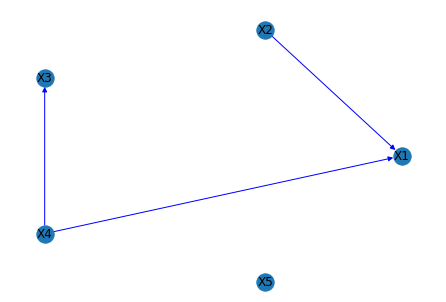

In [78]:
cg.to_nx_graph()

In [50]:
cg.__dir__()

['G',
 'data',
 'test',
 'corr_mat',
 'sepset',
 'definite_UC',
 'definite_non_UC',
 'PC_elapsed',
 'redundant_nodes',
 'nx_graph',
 'nx_skel',
 'labels',
 'prt_m',
 'mvpc',
 'cardinalities',
 'is_discrete',
 'citest_cache',
 'data_hash_key',
 'ci_test_hash_key',
 '__module__',
 '__init__',
 'set_ind_test',
 'ci_test',
 'neighbors',
 'max_degree',
 'find_arrow_heads',
 'find_tails',
 'find_undirected',
 'find_fully_directed',
 'find_bi_directed',
 'find_adj',
 'is_undirected',
 'is_fully_directed',
 'find_unshielded_triples',
 'find_triangles',
 'find_kites',
 'find_cond_sets',
 'find_cond_sets_with_mid',
 'find_cond_sets_without_mid',
 'rearrange',
 'to_nx_graph',
 'to_nx_skeleton',
 'draw_nx_graph',
 'draw_pydot_graph',
 '__dict__',
 '__weakref__',
 '__doc__',
 '__slotnames__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__new__',
 '__reduce_ex__',
 '__reduce__',
 '__sub